# Homework 5 - Databases

I implemented this using the SQLAlchemy ORM.
I'm working with three tables - airports, which has 50 entries, one for each airport, and is created from the info in the csv files given to us (I merged them in pandas). It contains primary key id, and info about the airport like the ICAO and location.
Weathers, which is made up of AirportWeather objects, is my other table. It has a primary key id, and a foreignkey aid, which links it to its airport. I stored the date, day, as a datetime object, the high+low temp, humidity, precipitation, and, just for fun, the name of the "events" occuring.
Finally, there's correlations, which stores the correlation between two airports 1,3, and 7 days in advance, for both the derivative (change in measure) and the measure itself. There are two correlations per pair of airports, one for high temp and one for precipitation.

In [1]:
import pandas as pd
from sqlalchemy import *
from bs4 import BeautifulSoup
import requests
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker
import datetime
import time
from multiprocessing import Pool
import numpy as np
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt

Here I'll set up the SQLAlchemy connection to the db and define my base classes

In [2]:
engine = create_engine('sqlite:///final3.db')
metadata = MetaData()
Base = declarative_base()

In [3]:
#create my table classes

class Airport(Base):
    __tablename__ = 'airports'
    id = Column(Integer, primary_key=True)
    ICAO = Column(String)
    city = Column(String)
    iso_region = Column(String)
    enplanements = Column(Integer)
    elevation_ft = Column(Float)
    latitude_deg = Column(Float)
    longitude_deg = Column(Float)
    weathers = relationship('AirportWeather', backref = 'Airport')
    
class AirportWeather(Base):
    __tablename__ = 'weathers'
    id = Column(Integer, primary_key=True)
    day = Column(Date) #this will be a datetime obj
    high = Column(Float)
    low = Column(Float)
    humidity = Column(Float)
    precipitation = Column(Float)
    events = Column(String)
    aid = Column(Integer, ForeignKey('airports.id'))
    

class Correlation(Base):
    __tablename__ = 'correlations'
    id = Column(Integer, primary_key = True)
    aid1 = Column(Integer, ForeignKey('airports.id'))
    aid2 = Column(Integer, ForeignKey('airports.id'))
    corr_1_adv = Column(Float)
    corr_3_adv = Column(Float)
    corr_7_adv = Column(Float)
    dv_corr_1_adv = Column(Float)
    dv_corr_3_adv = Column(Float)
    dv_corr_7_adv = Column(Float)
    measure = Column(String)
    airport1 = relationship('Airport', foreign_keys = "Correlation.aid1")
    airport2 = relationship('Airport', foreign_keys = "Correlation.aid2")


In [4]:
#actually create the session
Base.metadata.create_all(engine) 
Session = sessionmaker(bind=engine)
session = Session()

# Adding Data to Database Step 1 - Airports

Now I'll read in the given csvs, merge them, and populate the table with them

In [26]:
#read in csvs
top_airports_filename = "hw_5_data/top_airports.csv"
airport_info_filename = "hw_5_data/ICAO_airports.csv"
top_airports = pd.read_csv(top_airports_filename)
airport_info = pd.read_csv(airport_info_filename)

#homework suggests a single table for airports, so use pandas to merge these two tables
mrgd = top_airports.merge(airport_info, how='left',left_on = 'ICAO', right_on = 'ident')
#fix any nulls to be compatable with db
mrgd = mrgd.where(pd.notnull(mrgd), None)

In [27]:
#populate the airport table
for i,row in mrgd.iterrows():
    a = Airport(city = row.City, ICAO=row.ICAO, iso_region = row.iso_region, enplanements = row.Enplanements,
                elevation_ft = row.elevation_ft,
               longitude_deg = row.longitude_deg, latitude_deg = row.latitude_deg)
    session.add(a)
#then commit to the session
session.commit()

# Adding Data to Database Step 2 - Web Scraping
I go through each airport object and use the fxn add_weather_for_airport to add all the AirportWeather objects for that airport. I request the weather for the airport one year at a time from weather underground, since it doesn't consistently display time periods > one year. Thus, my outer loop is looping through years. I use BeautifulSoup to search through the html. The function is_td_has_no_class pulls out all elements in the table that are either months, dates, or weather information. Items that have classes in the table are header items like "high" or "Temperature", so I don't need those. Using beautifulsoups object properties, I get the contents of the entry and then the text.

This gives me a list of strings of table entries. If I hadn't included the months, every 21 strings would be one row, but every so often there is a string like "Jun" or "Jul" that doesn't belong to a row.

I get a list of strings that are the table entries, and then I loop through it, adding one row per loop, while keeping track of the current index I'm on. I also track the month. I first check if I'm at a month indicator, in which case I increment the month and the index. Then, I create a row object, which is the 21 strings that were entries in the same row. I create the date from the first entry in the row, the month, and the year. Then I handle missing data, and then insert into the database.

In [ ]:
def is_td_has_no_class(tag):
    """this is a function used to search the soup. All the items I want are named td but
    don't have a class definition, this will return True for them"""
    return tag.name =='td' and not tag.has_attr('class')

def add_weather_for_airport(a):
    #a list with all the strings weather undrgrnd uses to indicate months
    #these are so if I can check if an entry is a month
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ICAO = a.ICAO
    #loop thru years 2008-2018
    for curr_year in range(2008,2019):
        
        #if the year is 2018, get info through the current day
        if curr_year == 2018:
            weather_req = requests.get(
                "https://www.wunderground.com/history/airport/" + ICAO + \
                '/' +str(curr_year)+ '/1/1/CustomHistory.html?dayend=6&monthend=3&yearend='
                + str(curr_year))
        #otherwise get it through the end of the year
        else:
            weather_req = requests.get(
                "https://www.wunderground.com/history/airport/" + ICAO + \
                '/' +str(curr_year)+ '/1/1/CustomHistory.html?dayend=31&monthend=12&yearend='
                +str(curr_year))
            
        soup = BeautifulSoup(weather_req.text,"html.parser")
        #the desired table has id obsTable.
        tab = soup.find('table', id = 'obsTable')
        #entries like 'high' and 'Temperature have a class associated with them
        #all values I want don't have a class, so find tags with name td and no class
        table_entries=tab.find_all(is_td_has_no_class)
        
        #get the text for each of the tags.
        #if there is more than one thing in the contents, the middle one is the one we want
        table_entries_str = [str(entry.text) if len(entry.contents)==1 \
                             else str(entry.contents[1].text) \
                             for entry in table_entries]
        
        #table_entries_str now contains only the rows containing info, except that there
        #is also a string indicating the month every so often. Other than this, think
        #of it as a table with 21 entries per row, but every so often there's a month
        #val that isn't a part of a row
        curr_month = 0
        curr_ind = 0
        ncols = 21
        #each loop will add one AirportWeather object
        while curr_ind < len(table_entries_str)-1:
            #first check if theres a month indicator
            if table_entries_str[curr_ind] in months:
                curr_month += 1 #if it was in months, increment months
                curr_ind += 1 #don't include month values in rows

            row = table_entries_str[curr_ind:curr_ind+ncols]
            
            #now prepare the data for entry into the database
            
            #clean up some weird html stuff
            if '\t' in row[20]:
                row[20] = ''
            else:
                row[20] = row[20].replace('\n','')

            #create a datetime.date object for the date
            dateday = datetime.date(int(curr_year), curr_month, int(row[0]))
            
            #sometimes the precipitation is 'T', count that as being none
            if row[19]=='T':
                row[19]=None
            
            #otherwise, if the value is '-', its missing and thus None
            for i,s in enumerate(row):
                if s is not None:
                    if '-' in s:
                        row[i]=None
            
            aw=AirportWeather(day = dateday, high = row[1], low = row[3], humidity = row[8],
                              precipitation =  row[19], events = row[20], aid = a.id)
            session.add(aw)
            curr_ind += ncols #increment curr_ind

In [ ]:
airport_list = session.query(Airport).all()
for a in airport_list[0:50]:
    add_weather_for_airport(a)
    session.commit()

## (alternative - loading from csv to populate database)

Since the web scrapping takes so long and I sometimes wanted to alter my database (like when fiddling with how I store correlations), I also stored all my webscrapped data to a csv and sometimes loaded that to populate the database.

I included my code for this because I figured if something went wrong with my web scraping or you didn't want to wait for it this might be nice!

In [28]:
wdf = pd.read_csv('50airportsweather.csv')

wdf.day = pd.to_datetime(wdf.day, format='%Y-%m-%d', errors='coerce')

#then populate the weather table
session.rollback()
for i,row in wdf.iterrows():
    aw = AirportWeather(day = row.day, high = row.high, low=row.low, humidity = row.humidity,
                       precipitation = row.precipitation,
                events = row.events,
               aid = row.aid)
    session.add(aw)
#then commit to the session
session.commit()

# Adding Data to Database Step 3 -  Get Correlations
Basic steps: Retrieve data from the database. Create pandas series to represent the weather for each airport, and using pandas functionality, add missing dates then fill missing values.
After, get the derivative of each series using the diff function because dt is just 1.
Then shift the series to calculate the correlation for 1, 3, or 7 days in advance. Do this by just taking the the values of the series from 1:end, 3:end or 7:end.
Then loop through the original, unshifted serieses and for each series (so each airport), remove the end 1,3, or 7 elements to match the length of the shifted arrays, then get the correlation strengths for each of the days and for both the derivative and the original values. Add these as correlation objects. Do this whole process for both high temp and precipitation.

In [29]:
#first do high then do precipitation
for k in range(0,2):
    #first retrieve data, convert to pandas series, and fill missing values
    
    #create a list of lists, where each sublist is all vals for one aiport
    if k == 0:
        all_airports_vals = [[aw.high for aw in a.weathers] \
                          for a in session.query(Airport).all()]
    else:
        all_airports_vals = [[aw.precipitation for aw in a.weathers] \
                          for a in session.query(Airport).all()]
        
    #create a corresponding one of dates
    #because sometimes there are missing dates, we need to know the dates that correspond to each high 
    all_airports_dates = [[aw.day for aw in a.weathers] \
                               for a in session.query(Airport).all()]

    #convert the sublists into pandas series, with the index being the date
    series_values = [pd.Series(all_airports_vals[i], all_airports_dates[i]) \
       for i in range(0, len(all_airports_dates))]

    #create a fully populated date range (no missing dates)
    new_ind = pd.date_range('01-01-2008', '03-06-2018')
    #and use to fill in missing dates in each series (creates none entries)
    series_values = [ser.reindex(new_ind) for ser in series_values]

    #fill in missing data w/sequence of methods
    series_values = [ser.interpolate(method='time') for ser in series_values]
    series_values = [ser.fillna(method='bfill') for ser in series_values]
    series_values = [ser.fillna(method='ffill') for ser in series_values]

    #take the derivative (dt is always 1, so its just subtracting entry n - entry n-1)
    series_values_dv = [ser.diff()[1:] for ser in series_values]

    #then pre-create the shifted data that each airport will be compared to 
    #basically this is the values from each series, but shifted one, three, or seven to the right
    #subtract off the means while doing so bc that's a good idea
    all_vals_1 = [ser[1:].values - np.mean(ser[1:].values) for ser in series_values]
    all_vals_3 = [ser[3:].values - np.mean(ser[3:].values) for ser in series_values]
    all_vals_7 = [ser[7:].values - np.mean(ser[7:].values) for ser in series_values]
    all_vals_dv_1 = [ser[1:].values - np.mean(ser[1:].values) for ser in series_values_dv]
    all_vals_dv_3 = [ser[3:].values - np.mean(ser[3:].values) for ser in series_values_dv]
    all_vals_dv_7 = [ser[7:].values - np.mean(ser[7:].values) for ser in series_values_dv]


    #then loop through each of the original series, and compare it to the shifted ones
    for i, ser in enumerate(series_values):
        #cut off the end so it matches the length of the shifted ones, and subtract the mean
        ser1 = ser[0:len(ser)-1] - np.mean(ser[0:len(ser)-1])
        ser3 = ser[0:len(ser)-3] - np.mean(ser[0:len(ser)-3])
        ser7 = ser[0:len(ser)-7] - np.mean(ser[0:len(ser)-7])

        #also get the derivative series
        serdv = series_values_dv[i]
        serdv1 = serdv[0:len(serdv)-1] - np.mean(serdv[0:len(serdv)-1])
        serdv3 = serdv[0:len(serdv)-3] - np.mean(serdv[0:len(serdv)-3])
        serdv7 = serdv[0:len(serdv)-7] - np.mean(serdv[0:len(serdv)-7])

        #then do the correlation for all of them 
        corr1 = np.corrcoef(ser1,all_vals_1)
        corrdv1 = np.corrcoef(serdv1, all_vals_dv_1)
        corr3 = np.corrcoef(ser3,all_vals_3)
        corrdv3 = np.corrcoef(serdv3, all_vals_dv_3)
        corr7 = np.corrcoef(ser7,all_vals_7)
        corrdv7 = np.corrcoef(serdv7, all_vals_dv_7)
        #the first row excluding the first column has the entries we want 
        #loop through each of the other airport ids and add to the database
        if k==0:
            measure = 'high'
        else:
            measure = 'precipitation'
        for j in range(1,51):
            #don't add for an airport to itself
            if i+1 == j:
                continue
            session.add(Correlation(aid1 = i+1, aid2=j, corr_1_adv = corr1[0,j],
                                    corr_3_adv = corr3[0,j], corr_7_adv = corr7[0,j],
                                    dv_corr_1_adv = corrdv1[0,j], dv_corr_3_adv = corrdv3[0,j],
                                   dv_corr_7_adv = corrdv7[0,j], measure = measure))
            session.commit()

# Plot Top Pairs

I interpretted the homework to mean take the daily change in temperature, as in the derivative, but I found the correlations for both derivative and normal values, and I plotted both (derivative is top two, non-derivative is bottom two plots). I found that the non-derivative mostly seemed to reflect similarities between overall climate in airports that were close to each other. Thus, I only commented on trends for the correlation between the derivatives, as I felt these were more meaningful

TRENDS I SEE FOR DERIVATIVES: 
For both precipitation and high temperature, the distances definitely get bigger between the 1 day and 3 day strong pairs. There doesn't seem to be much difference between distances at 3 and 7 days in advance. This pattern also holds for longitude difference - for high temperature and precipitation, it appears to get noticably larger between 1 and 3 but not so much for 3 and 7.  This is possibly because by seven days most specific weather patterns have either left the US or have significantly changed, so maybe by seven days you're more tracking cities with similar climates than actual weather patterns? 


Particularly for high temperatures, but also for precipitation, the correlation strengths for 1 day in advance are quite a bit higher than the others. This makes sense, as weather gets increasingly unpredictable with time (Jurassic Park tells me that this is a chaos theory thing).


For high temperatures, the longitude differences are nearly all negative which indicates that weather is moving from west to east, as would be expected. However, for precipitation, the differences in longitude aren't shifted towards the negative. For 1 day in advance they're at about 0 for the most part - which makes sense, since storms may be in one area for several days, but for 3 days there doesn't seem to be any pattern and by 7 days they tend towards positive longitude differences - I'm not sure why that would be! The correlation strengths are all quite low, so its possible its not meaningful. Possibly hurricanes are also influencing precipitation more than temperature, as they move east to west.



In [5]:
#add a function to calculate distance from latitude and longitude using the haversine formula

def distance_from_long_lat(lat1, lat2, long1, long2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    long1 = radians(long1)
    lat2 = radians(lat2)
    long2 = radians(long2)

    dlong = long2 - long1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlong / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

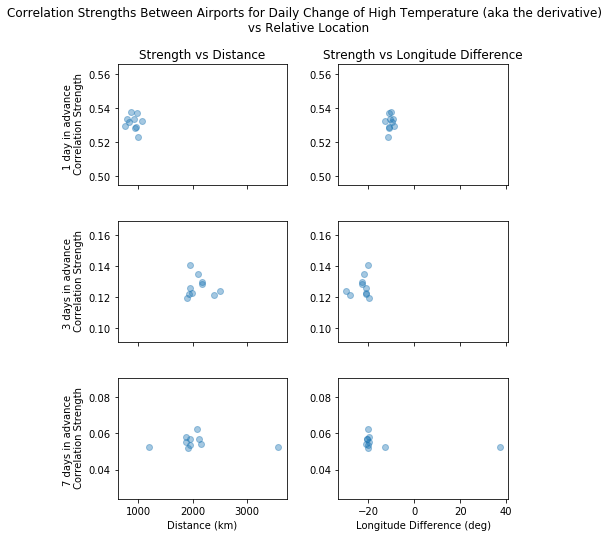

In [14]:
f,axes = plt.subplots(3,2, sharex='col')
plt.subplots_adjust(wspace = .3, hspace = .3)
f.set_size_inches(7,8)

axes[0,0].set_title('Strength vs Distance')
axes[0,1].set_title('Strength vs Longitude Difference')
axes[0,0].set_ylabel('1 day in advance \n Correlation Strength')
axes[1,0].set_ylabel('3 days in advance \n Correlation Strength')
axes[2,0].set_ylabel('7 days in advance \n Correlation Strength')
axes[2,0].set_xlabel('Distance (km)')
axes[2,1].set_xlabel('Longitude Difference (deg)')
plt.suptitle('Correlation Strengths Between Airports for Daily Change of High Temperature (aka the derivative) \n vs Relative Location')

for i in range(0,3):
    if i==0:
        top = session.query(Correlation).filter(Correlation.measure == 'high'). \
            order_by(desc(Correlation.dv_corr_1_adv)).all()[0:10]
        strengths = [c.dv_corr_1_adv for c in top]
    elif i==1:
        top = session.query(Correlation).filter(Correlation.measure == 'high'). \
            order_by(desc(Correlation.dv_corr_3_adv)).all()[0:10]
        strengths = [c.dv_corr_3_adv for c in top]
    else:
        top = session.query(Correlation).filter(Correlation.measure == 'high'). \
            order_by(desc(Correlation.dv_corr_7_adv)).all()[0:10]
        strengths = [c.dv_corr_7_adv for c in top]
    
    #get the distances and longitude differences between the top ten pairs
    dists = []
    longdiffs = []
    for c in top:
        long1, lat1 = c.airport1.longitude_deg, c.airport1.latitude_deg
        long2, lat2 = c.airport2.longitude_deg, c.airport2.latitude_deg
        dists.append(distance_from_long_lat(lat1, lat2, long1, long2))
        longdiffs.append(long1-long2)

    axes[i,0].scatter(dists, strengths, alpha = .4)
    axes[i,1].scatter(longdiffs, strengths, alpha = .4)

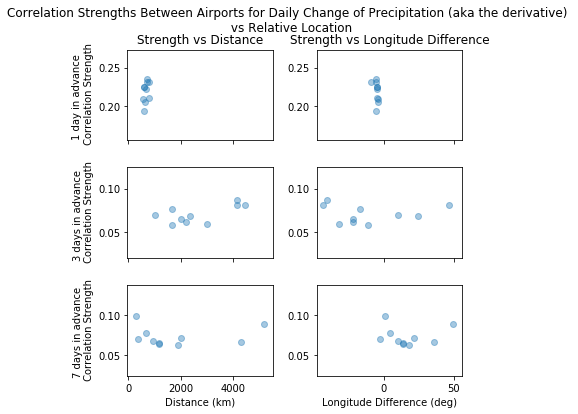

In [19]:
f,axes = plt.subplots(3,2, sharex='col')
plt.subplots_adjust(wspace = .3, hspace = .3)
f.set_size_inches(7,8)

axes[0,0].set_title('Strength vs Distance')
axes[0,1].set_title('Strength vs Longitude Difference')
axes[0,0].set_ylabel('1 day in advance \n Correlation Strength')
axes[1,0].set_ylabel('3 days in advance \n Correlation Strength')
axes[2,0].set_ylabel('7 days in advance \n Correlation Strength')
axes[2,0].set_xlabel('Distance (km)')
axes[2,1].set_xlabel('Longitude Difference (deg)')
plt.suptitle('Correlation Strengths Between Airports for Daily Change of Precipitation (aka the derivative) \n vs Relative Location')

for i in range(0,3):
    if i==0:
        top = session.query(Correlation).filter(Correlation.measure == 'precipitation'). \
            order_by(desc(Correlation.dv_corr_1_adv)).all()[0:10]
        strengths = [c.dv_corr_1_adv for c in top]
    elif i==1:
        top = session.query(Correlation).filter(Correlation.measure == 'precipitation'). \
            order_by(desc(Correlation.dv_corr_3_adv)).all()[0:10]
        strengths = [c.dv_corr_3_adv for c in top]
    else:
        top = session.query(Correlation).filter(Correlation.measure == 'precipitation'). \
            order_by(desc(Correlation.dv_corr_7_adv)).all()[0:10]
        strengths = [c.dv_corr_7_adv for c in top]
    
    #get the distances and longitude differences between the top ten pairs
    dists = []
    longdiffs = []
    for c in top:
        long1, lat1 = c.airport1.longitude_deg, c.airport1.latitude_deg
        long2, lat2 = c.airport2.longitude_deg, c.airport2.latitude_deg
        dists.append(distance_from_long_lat(lat1, lat2, long1, long2))
        longdiffs.append(long1-long2)

    axes[i,0].scatter(dists, strengths, alpha = .4)
    axes[i,1].scatter(longdiffs, strengths, alpha = .4)

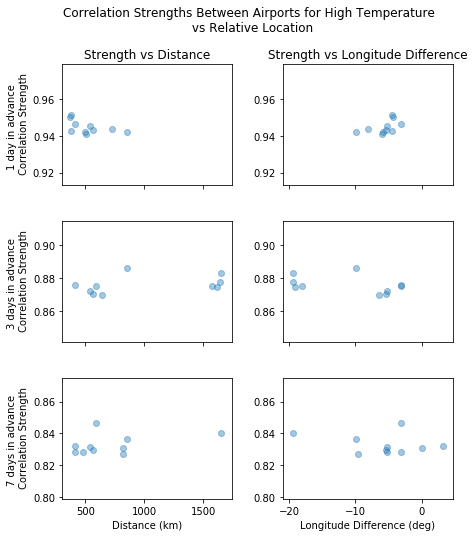

In [20]:
f,axes = plt.subplots(3,2, sharex='col')
plt.subplots_adjust(wspace = .3, hspace = .3)
f.set_size_inches(7,8)

axes[0,0].set_title('Strength vs Distance')
axes[0,1].set_title('Strength vs Longitude Difference')
axes[0,0].set_ylabel('1 day in advance \n Correlation Strength')
axes[1,0].set_ylabel('3 days in advance \n Correlation Strength')
axes[2,0].set_ylabel('7 days in advance \n Correlation Strength')
axes[2,0].set_xlabel('Distance (km)')
axes[2,1].set_xlabel('Longitude Difference (deg)')
plt.suptitle('Correlation Strengths Between Airports for High Temperature \n vs Relative Location')

for i in range(0,3):
    if i==0:
        top = session.query(Correlation).filter(Correlation.measure == 'high'). \
            order_by(desc(Correlation.corr_1_adv)).all()[0:10]
        strengths = [c.corr_1_adv for c in top]
    elif i==1:
        top = session.query(Correlation).filter(Correlation.measure == 'high'). \
            order_by(desc(Correlation.corr_3_adv)).all()[0:10]
        strengths = [c.corr_3_adv for c in top]
    else:
        top = session.query(Correlation).filter(Correlation.measure == 'high'). \
            order_by(desc(Correlation.corr_7_adv)).all()[0:10]
        strengths = [c.corr_7_adv for c in top]
    
    #get the distances and longitude differences between the top ten pairs
    dists = []
    longdiffs = []
    for c in top:
        long1, lat1 = c.airport1.longitude_deg, c.airport1.latitude_deg
        long2, lat2 = c.airport2.longitude_deg, c.airport2.latitude_deg
        dists.append(distance_from_long_lat(lat1, lat2, long1, long2))
        longdiffs.append(long1-long2)

    axes[i,0].scatter(dists, strengths, alpha = .4)
    axes[i,1].scatter(longdiffs, strengths, alpha = .4)

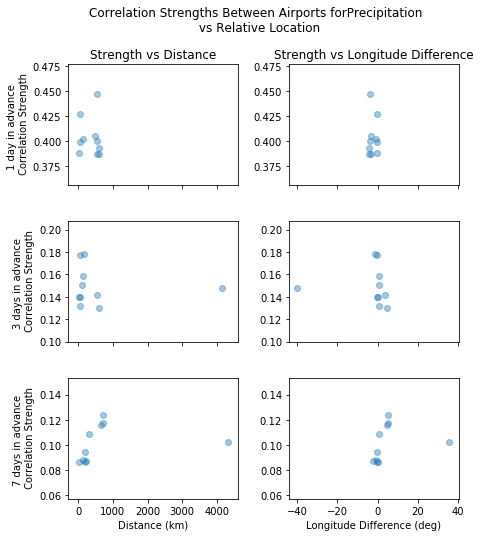

In [21]:
f,axes = plt.subplots(3,2, sharex='col')
plt.subplots_adjust(wspace = .3, hspace = .3)
f.set_size_inches(7,8)

axes[0,0].set_title('Strength vs Distance')
axes[0,1].set_title('Strength vs Longitude Difference')
axes[0,0].set_ylabel('1 day in advance \n Correlation Strength')
axes[1,0].set_ylabel('3 days in advance \n Correlation Strength')
axes[2,0].set_ylabel('7 days in advance \n Correlation Strength')
axes[2,0].set_xlabel('Distance (km)')
axes[2,1].set_xlabel('Longitude Difference (deg)')
plt.suptitle('Correlation Strengths Between Airports forPrecipitation \n vs Relative Location')

for i in range(0,3):
    if i==0:
        top = session.query(Correlation).filter(Correlation.measure == 'precipitation'). \
            order_by(desc(Correlation.corr_1_adv)).all()[0:10]
        strengths = [c.corr_1_adv for c in top]
    elif i==1:
        top = session.query(Correlation).filter(Correlation.measure == 'precipitation'). \
            order_by(desc(Correlation.corr_3_adv)).all()[0:10]
        strengths = [c.corr_3_adv for c in top]
    else:
        top = session.query(Correlation).filter(Correlation.measure == 'precipitation'). \
            order_by(desc(Correlation.corr_7_adv)).all()[0:10]
        strengths = [c.corr_7_adv for c in top]
    
    #get the distances and longitude differences between the top ten pairs
    dists = []
    longdiffs = []
    for c in top:
        long1, lat1 = c.airport1.longitude_deg, c.airport1.latitude_deg
        long2, lat2 = c.airport2.longitude_deg, c.airport2.latitude_deg
        dists.append(distance_from_long_lat(lat1, lat2, long1, long2))
        longdiffs.append(long1-long2)

    axes[i,0].scatter(dists, strengths, alpha = .4)
    axes[i,1].scatter(longdiffs, strengths, alpha = .4)